# ICV. Project

**Student Information**: Anna Boronina

**Group**: BS18-DS-01 

**Telegram**: @whoorma




## Installs and imports

[The link to the results](https://drive.google.com/drive/folders/1b6MuCJwhsIQXu-wUQzByxQlwEQp8JUsu?usp=sharing).

[The link to the Colab Notebook](https://colab.research.google.com/drive/15Ohc_B71a1okiOJwj8_jiNJ6mQQoaz5b?usp=sharing).

[The link to the Colab Notebook for project after progress report]()

**If you want to run the code**, you can download videos without word _detected_ in their names from folder *videos/* (follow the link above) and save it in this session to folder _videos/_ after it's created in the next cell.

**If you want to see the results**, follow the same link from above and open the files.

In [ ]:
from IPython.display import clear_output, HTML

!mkdir images
!mkdir videos

# download the images
!wget https://i.imgur.com/OWfrJiN.jpg -O images/people1.jpg
!wget https://i.imgur.com/nSv2djx.png -O images/people2.png
!wget https://i.imgur.com/rfIBzFP.jpg -O images/people3.jpg
!wget https://i.imgur.com/fVzKws2.jpg -O images/people4.jpg
!wget https://i.imgur.com/0o2RcED.jpg -O images/people5.jpg
!wget https://i.imgur.com/50zrhAl.png -O images/people6.png

# paths to the images
IMAGES = [
          'images/people1.jpg',
          'images/people2.png',
          'images/people3.jpg',
          'images/people4.jpg',
          'images/people5.jpg',
          'images/people6.png'
          ]

# paths to the videos
VIDEOS = [
          'videos/people_walking1.mp4',
          'videos/people_walking2.mp4',
          'videos/people_walking3.mp4',
          'videos/people_walking4.mp4',
          'videos/people_exercising1.mp4',
          'videos/people_exercising2.mp4',
          'videos/people_exercising3.mp4',
          'videos/people_exercising4.mp4',
          ]

clear_output()

In [ ]:
!pip install mediapy
!pip install imgaug==0.2.5
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python==4.5.1.48
!pip install -U kora
clear_output()

In [ ]:
from enum import Flag, auto

import torch
from torchvision.transforms import transforms
from torchvision.models.detection import keypointrcnn_resnet50_fpn
import torch.nn as nn

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mediapy import VideoWriter, read_video

import numpy as np
from time import time

from collections import OrderedDict
from kora.drive import upload_public
from base64 import b64encode
from os import listdir

In [ ]:
cv2.__version__ # should be 4.5.1

'4.5.1'

## Global variables

In [ ]:
# KeypointRCNN returns 17 classes, one for each body point it detects
key2bodypart = {
    0: 'nose',
    1: 'left eye',
    2: 'right eye',
    3: 'left ear',
    4: 'right ear',
    5: 'left shoulder',
    6: 'right shoulder',
    7: 'left elbow',
    8: 'right elbow',
    9: 'left wrist',
    10: 'right wrist',
    11: 'left hip',
    12: 'right hip',
    13: 'left knee',
    14: 'right knee',
    15: 'left ankle',
    16: 'right ankle'
}

# body points to connect to get a human shape
connected_pairs = [
                   (0, 1), (0, 2), (1, 2), (2, 4), (1, 3),  # face
                   (5, 6), (5, 7), (7, 9), (6, 8), (8, 10), # arms
                   (5, 11), (6, 12),                        # middle part of the body
                   (11, 13), (12, 14), (13, 15), (14, 16)   # legs
]

class Device(Flag):
    GPU = auto()
    CPU = auto() 

I do not apply any normalization for the images because doing it gave worse results.

In [ ]:
# transformation from image to tensor - no normalization
TRANSFORM = transforms.Compose([
                                transforms.ToTensor()
])

# define the model
model = keypointrcnn_resnet50_fpn(pretrained=True)
# define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# set the model to the testing mode
model.to(device).eval()
clear_output()

In [ ]:
def show_in_row(list_of_images, titles = None, disable_ticks = True):
    '''
    shows multiple images in one row; credit: Karam
    @param list_of_images: list of image to show
    @param titles: list of titles for images; default is None
    @param disable_ticks: whether to show ticks for images or not; default is False

    @return None
    '''
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])
        
        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
def draw_body(all_keypoints, all_scores, connected_pairs, image, color_edges=(200, 0, 0), color_lines=(0, 200, 0), threshold=0.95, device=Device.CPU):
    '''
    draws human shape on an image
    @param all_keypoints: keypoints returned by the model;
                        contains one entry per human
    @param all_scores: score for each detected human
    @param connected_pairs: body points to connect; list of pairs
    @param image: the image used for humans detection
    @param color_edges: color for drawing edges; default is red
    @param color_lines: color for drawing lines, which connect edges; default is green
    @param threshold: threshold for score; default is 0.95

    @return a copy of the original image with human shape(s) drawn in it
    '''
    imagecopy = image.copy()
    for keypoints, score in zip(all_keypoints, all_scores):
        if score < threshold:
            continue
        if len(keypoints.shape) == 3:
            keypoints = keypoints.reshape(-1, 3)
        if device == Device.GPU:
            keypoints = keypoints.cpu().detach().numpy()

        for idx, keypoint in enumerate(keypoints):
            x, y = keypoint[0], keypoint[1]
            connect_to = filter(lambda p: p[0] == idx, connected_pairs)
            for con in connect_to:
                xx, yy = int(keypoints[con[1]][0].item()), int(keypoints[con[1]][1].item())
                cv2.line(imagecopy, (x, y), (xx, yy), color_lines, thickness=3)
            cv2.circle(imagecopy, (x, y), 3, color_edges, thickness=-1, lineType=cv2.FILLED)

    return imagecopy

## Images

In [ ]:
def read_image(path):
    '''
    reads the image given a path
    @param path: path to the image
    @return image as numpy.ndarray
    '''
    orig_image = cv2.imread(path)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    return orig_image


def detect_body(orig_image, model, transform=TRANSFORM, show=True):
    '''
    detects human shape(s) in a given image
    @param orig_image: path to the image
    @param model: model to use for human shape detection
    @param transform: transformation for the image before passing to the model;
                      default is global TRANSFORM
    @param show: whether to show the image after detecting the shape or not;
                 default is True
    @return image as numpy.ndarray
    '''
    image = transform(orig_image)
    image = image.unsqueeze(0).to(device)

    start_time = time()
    with torch.no_grad():
        result = model(image)[0]
    end_time = time()

    new_image = draw_body(result['keypoints'], result['scores'], connected_pairs, orig_image)
  
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(new_image)
    return result, new_image, end_time-start_time

In [ ]:
def get_new_name(name, postfix='detected'):
    '''
    generates a new name for file
    @param name: original file name
    @param postfix: postfix to add to the generated filename; default is 'detected'
    @return the generated name 
    '''
    name, ext = name.split('.')
    return f'{name}_{postfix}.{ext}'

In [ ]:
def read_detect_save_images(paths, model, show=False):
    '''
    reads images, detects human shapes in them, saves new images
    @param paths: list of paths to the images
    @param model: model to use for human shape detection
    @param show: whether to show the images or not; default is False
    @return None
    '''
    for path in paths:
        image = read_image(path)
        _, new_image, _ = detect_body(image, model)
        new_name = get_new_name(path)
        _ = cv2.imwrite(new_name, cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))
        show_in_row([image, new_image])

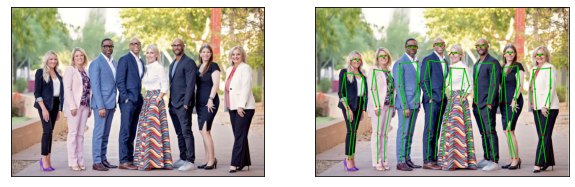

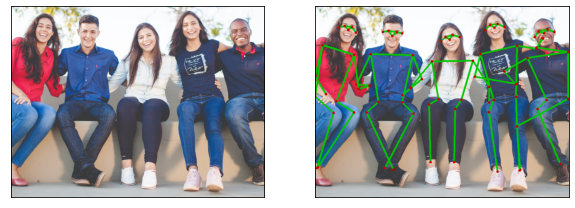

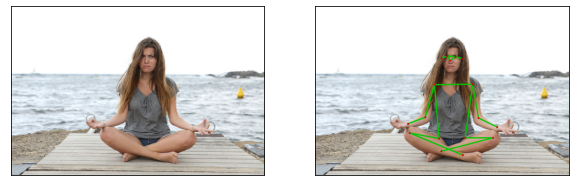

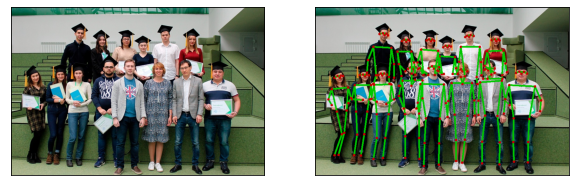

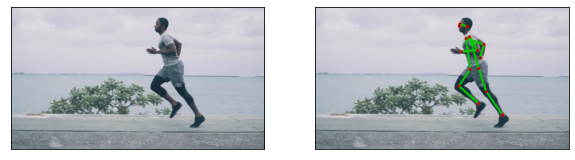

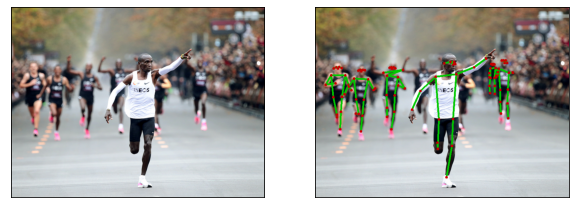

In [ ]:
read_detect_save_images(IMAGES, model, show=True)

## Videos

In [ ]:
def read_video(path):
    '''
    read one video
    @param path: path to the video
    @return cap: video object, contains main video information
    @return fwidth: frame width
    @return fheight: frame height
    @return fps: frames per second of the video
    '''
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return
    fwidth, fheight = int(cap.get(3)), int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)
    return cap, fwidth, fheight, int(fps)


def play_video(cap):
    '''
    play one video if not in colab
    @param cap: video object, contains main video information
    @return None
    '''
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        cv2.imshow('', frame)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break


def play_video_colab(path):
    '''
    play one video in colab
    @param path: path or url to the video
    @return html object with video
    '''
    video = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video).decode()
    return HTML(f"""
    <video width=400 controls>
        <source src={data_url} type="video/mp4">
    </video>
    """)

def detect_bodies_in_video(cap, model):
    '''
    play one video
    @param cap: video object, contains main video information
    @param model: model to use for human shape detection
    @return frames with human detected in each of them
    '''
    new_frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            return new_frames
        img = np.uint8(Image.fromarray(frame).convert('RGB'))
        _, new_img, time_spent = detect_body(img, model, show=False)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
        fps = 1 / time_spent
        wait_time = max(1, int(fps / 4))
        new_frames.append(new_img)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
    return new_frames

def save_new_video(save_to, frames):
    '''
    save one video
    @param save_to: an instance of class mediapy.VideoWriter
    @frames: frames for the new video
    @return None
    '''
    for frame in frames:
        save_to.add_image(frame)

In [ ]:
def read_detect_save_videos(paths, model):
    '''
    reads videos, detects human shapes in them, saves new videos
    @param paths: list of paths to the videos
    @param model: model to use for human shape detection
    @return None
    '''
    for path in paths:
        try:
            videocap, fwidth, fheight, fps = read_video(path)
            new_name = get_new_name(path)
            new_frames = detect_bodies_in_video(videocap, model)
            if new_frames:
                with VideoWriter(new_name, fps=fps, shape=(fheight, fwidth)) as save_to:
                    save_new_video(save_to, new_frames)
            else:
                print(f'Video was corrupted, path: {path}')
        except:
            print(f'Check that the video exists, path: {path}')

In [ ]:
read_detect_save_videos(VIDEOS, model)

Colab is not very good with playing the videos. So the best way to see them is to basically download them or follow the link given at the beginning of the document.

If you want to play just one video, do:
```python
play_video_colab(path_to_video)
```